In [65]:
from __future__ import division
from IPython.core.display import display, HTML
from pprint import pprint
from bs4 import BeautifulSoup
import urllib2
import requests
import pandas as pd
import numpy as np
import re
import os
import time
# from tqdm import tqdm
import thread as th
from time import sleep
import matplotlib.pyplot as plt
import matplotlib.figure as fig


In [46]:
########  USER INPUTS  ###################
longWork = True
beautify = True
sourceFile = False
HTMLfolderName = 'LocalHTML'
#Enter the link of the channel here
urlList = list()
handle = open('./ChannelList.txt','r')
for a in handle:
    ss = re.findall('https://www.youtube.com/.*videos',a)
    if len(ss):
        urlList.append(ss[0])
handle.close()


#############################################

def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' if val > 10 else 'black'
    return 'color: %s' % color

def soupMaker(obj,isUrl=True):
    '''converts to Soup object'''
    #True takes the link(obj)
    #False: the file name of the local HTML is taken
    
    if isUrl:
        print "In true"
        sc = requests.get(obj)
        soup = BeautifulSoup(sc.text,'html.parser')
    else:
        print "In false"
#         obj.find('video')
        try:
            sc = open('./'+HTMLfolderName+"/"+obj+'.html','r').read()
        except:
            print "FILE NOT FOUND",ChannelName
        soup = BeautifulSoup(sc,'html.parser')
        
    return soup

def getUpload(href):
    #This is the Date of upload of the video individual video
	url="https://www.youtube.com"+href
	sc = requests.get(url)
	oo = str()
	soup = BeautifulSoup(sc.text,'html.parser')
	oo = soup.find_all("strong", class_="watch-time-text")[0].text[13:]
	return oo
	# return date

def buildDict(listValuePair):
	di = dict()
	for col,row in listValuePair:
		di[col] = row 
	return di

def channelTotal(url):
    global TotalViews,TotalSubscriber,ChannelName
    urlAbout = url.replace('videos','about')
    sc = requests.get(urlAbout)
    soup = BeautifulSoup(sc.text,'html.parser')
#    soup = soupMaker(isUrl=False,obj=urlAbout)
    about_list = soup.find_all("span",class_="about-stat")
    # subdcribers = about_list[0].span.text
    TotalViews = about_list[1].text[2:]
    TotalSubscriber = about_list[0].text
    ChannelName=soup.title.text.replace('YouTube','').replace('-','').replace('\n','')
    print "----------", ChannelName.upper() ,"----------"
    print "Total Views: ", TotalViews
    print "Total Subscribers: ", TotalSubscriber
    print about_list[2].text
    
def viewDataFrames():
    for nxtfile in os.listdir('./DataFrames'):
        print nxtfile
        df_view = pd.read_pickle('DataFrames/'+ nxtfile)
        display(HTML(df_view.head(10).to_html()))
        
        
# viewDataFrames()
   
def main():
	for url in urlList:
		print url
		try:
		 	channelTotal(url)
		except:
		 	continue
	# 	th.start_new_thread( channelTotal, (url,) )

		if sourceFile :
			soup = soupMaker(ChannelName.strip()+' - YouTube',False)#soup = BeautifulSoup(sc.text,'html.parser')
		else:
			soup = soupMaker(url,isUrl=True)
	        
		video_Alllists = soup.find_all("div", class_="yt-lockup-content")
		title = list()
		duration = list()
		uploadLag = list()
		date = list()
		view = list()
		viewPercent = list()
		d = dict()

		for line in video_Alllists:
			if longWork:
				date.append(getUpload(line.a.get('href')))
				
			uploadLag.append(line.find_all('li')[1].text)
			view.append(line.li.text)
			title.append(line.a.get('title'))
			duration.append(re.findall('\d.*',line.span.text)[0][:-1])
            
		datePD = pd.Series(date)    
		titlePd = pd.Series(title)
		durPd = pd.Series(duration)
		viewPd = pd.Series(view)
		uploadLagPd = pd.Series(uploadLag)
		attributes = [('Title',titlePd),('Duration',durPd),('Views',viewPd),('Upladed Ago',uploadLagPd)]

		d = buildDict(attributes)
		df = pd.DataFrame(d)
	    
	    
		if longWork:
			df['Date'] = pd.Series(date)
		   
		
		if not os.path.isfile('./DataFrames/'+ChannelName):
			df.to_pickle('DataFrames/'+ ChannelName)
	        
		
		df_old = pd.read_pickle('DataFrames/'+ ChannelName)
		df = pd.concat([df,df_old]).drop_duplicates(subset=['Duration','Title']).reset_index(drop=True)
	#     ,ignore_index=True
	# 	try:
	# 		fake = df_old.analyticStartDate
	# 	except:
	# 		df.analyticStartDate = time.ctime()
	# 	print "Analytics Starting time:",df.analyticStartDate
	    
	# 	#Updating the saves
		df.to_pickle('DataFrames/'+ ChannelName)  
	    
		#Finding the %age of the views
		view_sum = int(TotalViews.replace('views',' ').replace(',',''))
		for eachView in df['Views']:
		    viewPercent.append(round(int(eachView.replace('views',' ').replace(',',''))/view_sum*100,2))
		viewPercentPd = pd.Series([str(a) +'%' for a in viewPercent])
		df['View Percentage'] = viewPercentPd
	    
	    #Display
		if beautify:
			display(HTML(df.to_html()))
		else:
			s = df.style.applymap(color_negative_red)
			df.style.bar(subset=['Views'], color='#d65f5f') ##Fails because its in string
	print "======Done====="
    
main() 


  Soshi Entertainment  


,Date,Duration,Title,Upladed Ago,Views
0,"Feb 26, 2016","3 minutes, 6 seconds",how would snsd sing red dress by red velvet? (...,6 months ago,436 views
1,"Jan 17, 2016","6 minutes, 11 seconds",[FMV] BTs - Butterfly by SOSHI ENTERTAINMENT,7 months ago,33 views
2,"Nov 22, 2015","2 minutes, 24 seconds",EXID Hot Pink Ranking,9 months ago,108 views
3,"Nov 10, 2015","3 minutes, 30 seconds",how would SNSD sing ice cream cake by Red velvet?,10 months ago,132 views
4,"Nov 3, 2015","3 minutes, 52 seconds",how would snsd sing nonono by Apink?,10 months ago,426 views
5,"Nov 3, 2015","3 minutes, 40 seconds",how would red velvet sing shake it by SISTAR?,10 months ago,45 views
6,"Nov 3, 2015","3 minutes, 38 seconds",how would snsd sing 4 walls by f(x)?,10 months ago,182 views
7,"Nov 2, 2015","4 minutes, 6 seconds",how would snsd sing diamond by f(x)?,10 months ago,460 views
8,"Nov 2, 2015","3 minutes, 1 second","[BaekYeon] eyes, nose, lips",10 months ago,452 views
9,"Oct 13, 2015",10 minutes,[SNSD OT9] Predebut Vs NOW member.ver,11 months ago,119 views


  2point5  


,Date,Duration,Title,Upladed Ago,Views
0,"Aug 6, 2016","5 minutes, 54 seconds",Indians React to PEWDIEPIE | FLAPPY BIRD - DON...,4 weeks ago,"1,241 views"
1,"Jul 2, 2016","2 minutes, 36 seconds",Indians React to AURA VR PRO - ROLLER COASTER ...,2 months ago,"2,347 views"
2,"Jun 25, 2016","6 minutes, 12 seconds",Indians React to KRK-All India Bakchod (AIB) K...,2 months ago,"2,979 views"
3,"May 28, 2016","3 minutes, 13 seconds",Indians React to AGAR.IO | 2point5,3 months ago,951 views
4,"May 21, 2016","8 minutes, 12 seconds",Indians React to CONDOM | 2point5,3 months ago,"4,239 views"
5,"May 14, 2016","4 minutes, 29 seconds",Indians React to LOVE RUDRAKASH -Delhi Hilario...,3 months ago,"1,961 views"
6,"May 7, 2016","3 minutes, 47 seconds",Indians React to POONAM PANDEY Style Yoga | 2p...,3 months ago,"5,339 views"
7,"Apr 30, 2016","4 minutes, 21 seconds",Indians React to K-POP - BTS -DOPE | 2point5,4 months ago,"32,702 views"
8,"Apr 23, 2016","3 minutes, 17 seconds",MEN TRY WINGED EYELINER | Indians React | 2point5,4 months ago,"1,209 views"
9,"Apr 16, 2016","3 minutes, 56 seconds",Indians React to VR - VIRTUAL REALITY | Insidi...,4 months ago,"2,668 views"


  Soshi News  


,Date,Duration,Title,Upladed Ago,Views
0,"Oct 7, 2015",5 minutes,[Vietsub] TAEYEON 태연_ I (feat. Verbal Jint) by...,11 months ago,88 views
1,"Sep 26, 2015","4 minutes, 11 seconds",GIRLS' GENERATION Aniversary OT9 with Jessica ...,11 months ago,352 views
2,"Sep 19, 2015","3 minutes, 44 seconds",All My Love Is For Hyoyeon By Soshi News,11 months ago,79 views
3,"Sep 7, 2015","4 minutes, 24 seconds",[Vietsub] INTO THE NEW WORLD (Ballad ) - SNSD...,1 year ago,"1,049 views"
4,"Sep 1, 2015","3 minutes, 35 seconds",[Vietsub] One Afternoon - SNSD in Tencent K-PO...,1 year ago,"44,826 views"
5,"Aug 30, 2015","3 minutes, 48 seconds",Paradise SNSD Made by Soshi News,1 year ago,64 views
6,"Aug 28, 2015","3 minutes, 35 seconds",One Afternoon - SNSD Made by Soshi News,1 year ago,145 views
7,"Aug 24, 2015","3 minutes, 18 seconds",[Vietsub] You think - SNSD by SoShi News,1 year ago,229 views
8,"Aug 4, 2015","3 minutes, 38 seconds",Girls' Generation 8th Anniversary by Soshi New...,1 year ago,795 views
9,"Aug 23, 2015","3 minutes, 47 seconds",150823 Girl's Generation 소녀시대 Lion Heart Com...,1 year ago,11 views


  idk what to call my channel...  


,Date,Duration,Title,Upladed Ago,Views
0,"an 13, 2010","2 minutes, 43 seconds",crabitat January 2010,6 years ago,"2,034 views"
1,"ug 22, 2009","2 minutes, 1 second",update on my crabitat,7 years ago,"13,609 views"
2,"ul 1, 2009","3 minutes, 6 seconds",SOME OF MY my tadpoles are now TOADLETS!!!!,7 years ago,"25,915 views"
3,"un 25, 2009","2 minutes, 26 seconds",hermit crab race,7 years ago,"19,223 views"
4,"un 24, 2009",75 seconds,coming this summer!!!!,7 years ago,"3,080 views"
5,"ay 30, 2009","2 minutes, 10 seconds",How to set up a tadpole tank,7 years ago,"68,133 views"
6,"pr 27, 2009","4 minutes, 54 seconds",Montee's new life,7 years ago,"5,844 views"
7,"ar 14, 2009","2 minutes, 13 seconds",crabitat update,7 years ago,"7,472 views"
8,"eb 28, 2009","2 minutes, 55 seconds",Hermi crab bath,7 years ago,"5,705 views"
9,"eb 28, 2009",49 seconds,Terrance,7 years ago,"1,272 views"


  boba.soshi  


,Date,Duration,Title,Upladed Ago,Views
0,"Jun 27, 2016",57 seconds,[FMV] Multifemale 2.0,2 months ago,42 views
1,"May 5, 2016",78 seconds,Svp 13 - Tutorial #1,4 months ago,79 views
2,"Apr 16, 2016","5 minutes, 33 seconds",K-pop Girl Group Dance Quiz,4 months ago,582 views
3,"Mar 28, 2016",39 seconds,♂ multimale ♂,5 months ago,102 views
4,"Mar 12, 2016",53 seconds,♀multifemale♀,6 months ago,108 views
5,"Mar 3, 2016",6 seconds,seohyun,6 months ago,249 views
6,"Feb 29, 2016",43 seconds,▲FMV▼ TAEYEON ☾ DOLLHOUSE☽,6 months ago,406 views


  PewDiePie  


,Duration,Title,Upladed Ago,Views,Date
0,"6 minutes, 51 seconds",UNMONETIZED,15 hours ago,"2,192,687 views","Sep 8, 2016"
1,10 minutes,GET PEWDIEPIE'D,1 day ago,"2,588,095 views","Sep 7, 2016"
2,"5 minutes, 8 seconds",I GOT PUNCHED?,2 days ago,"3,835,104 views","Sep 6, 2016"
3,1 hour,THE VANISHING OF POOPIEPIE,3 days ago,"3,791,590 views","Sep 5, 2016"
4,"7 minutes, 36 seconds",GIRLFRIEND VS BOYFRIEND: CHEF,4 days ago,"4,352,975 views","Sep 4, 2016"
5,"6 minutes, 18 seconds",DANK PEWDIEPIE SPICY MEMES,5 days ago,"3,872,640 views","Sep 3, 2016"
6,"6 minutes, 49 seconds",CRINGY KIDS ON THE INTERNET,6 days ago,"4,454,235 views","Sep 2, 2016"
7,"9 minutes, 12 seconds",THE GREATEST CAKE,1 week ago,"4,213,717 views","Sep 1, 2016"
8,"6 minutes, 21 seconds",WHY I GOT UNVERIFIED,1 week ago,"11,248,123 views","Aug 31, 2016"
9,"5 minutes, 29 seconds",WHAT IF...?,1 week ago,"4,140,346 views","Aug 30, 2016"


  IDK Games  


,Date,Duration,Title,Upladed Ago,Views
0,"Jul 12, 2016",32 minutes,Ori and the Blind Forest Part 13: Kuro's Venge...,2 months ago,19 views
1,"Jul 1, 2016",36 minutes,GET IN THE HOLE! - Golf With Your Friends Part 1,2 months ago,28 views
2,"Jun 30, 2016",42 minutes,Ultimate chicken Horse Part 1 - The Ultimate C...,2 months ago,10 views
3,"Jun 29, 2016",25 minutes,Planet Coaster Part 3 - Scenic Time Lapse,2 months ago,24 views
4,"Jun 28, 2016",33 minutes,RPG Maker MV Tutorial World - Battle System an...,2 months ago,91 views
5,"Jun 24, 2016",45 minutes,Planet Coaster Part 2 - First Coaster?!,2 months ago,36 views
6,"Jun 23, 2016",25 minutes,RPG Maker MV Tutorial World - Message System,2 months ago,50 views
7,"Jun 21, 2016",33 minutes,Planet Coaster Part 1 - A Brand New Park,2 months ago,44 views
8,"Jun 20, 2016",33 minutes,RPG Maker MV Tutorial World - Special Events,2 months ago,10 views
9,"Jun 8, 2016",32 minutes,RPG Maker MV Tutorial World - Event Commands,3 months ago,16 views


  Lyrics Soshi  


,Date,Duration,Title,Upladed Ago,Views
0,"Aug 4, 2016","4 minutes, 22 seconds",SNSD - Sailing/That Summer (0805) Acapella,1 month ago,812 views
1,"Aug 4, 2016","4 minutes, 24 seconds",SNSD - Sailing/That Summer (0805) Lyrics ( Rom...,1 month ago,"5,875 views"
2,"Jun 12, 2016","3 minutes, 42 seconds",EXO - Monster (Chinese Ver.) Acapella,3 months ago,82 views
3,"Jun 12, 2016","3 minutes, 42 seconds",EXO - Monster Acapella,3 months ago,257 views
4,"Jun 12, 2016","3 minutes, 48 seconds",EXO - Lucky One Acapella,3 months ago,189 views
5,"Jun 12, 2016","3 minutes, 48 seconds",EXO - Lucky One (Chinese Ver.) Acapella,3 months ago,54 views
6,"Jun 9, 2016","3 minutes, 41 seconds",EXO - Stronger Lyrics ( Romanization & Eng Sub ),3 months ago,182 views
7,"Oct 10, 2015","3 minutes, 37 seconds",SNSD - One Afternoon Lyrics ( Romanization & E...,11 months ago,166 views
8,"Oct 10, 2015","3 minutes, 18 seconds",SNSD - You Think Lyrics ( Romanization & Eng S...,11 months ago,94 views
9,"Oct 9, 2015","3 minutes, 39 seconds",Day6 - Like That Sun Lyrics ( Romanization & E...,11 months ago,75 views


  Infinity TV  


,Date,Duration,Title,Upladed Ago,Views
0,"Feb 18, 2015","2 minutes, 59 seconds",Checkmate !,1 year ago,572 views
1,"Feb 6, 2015",13 seconds,Checkmate |,1 year ago,169 views
2,"Feb 6, 2015","7 minutes, 16 seconds",Night before exams !,1 year ago,"5,961 views"
3,"Jan 26, 2015","5 minutes, 2 seconds",How to get a girlfriend?,1 year ago,"1,156 views"


  Thomas Scott News  


,Date,Duration,Title,Upladed Ago,Views
0,"Sep 12, 2016","2 minutes, 6 seconds",NASA ISS LIVE stream SKIPS (that is ghetto),13 hours ago,26 views
1,"Sep 10, 2016","4 minutes, 45 seconds",Dan Pratt Flat Earth Painting,2 days ago,61 views
2,"Sep 7, 2016",71 seconds,"The Stolen Earth ROCKSTAR ReMiXeD by Pizza T ""...",5 days ago,53 views
3,"Sep 1, 2016","5 minutes, 15 seconds",Matt Boylan globe unseen footage,1 week ago,139 views
4,"Aug 31, 2016","2 minutes, 27 seconds",DPTR on TSN taste test Crystal Pepsi 2016,1 week ago,34 views
5,"Aug 31, 2016",78 seconds,New York Seltzer Root Beer Taste Test 2016,1 week ago,26 views
6,"Aug 26, 2016",31 seconds,Truth About Pewdie Pie tsn goes hard,2 weeks ago,51 views
7,"Aug 17, 2016","3 minutes, 24 seconds",New Theme song update 4 Thomas Scott News,3 weeks ago,60 views
8,"Aug 14, 2016","2 minutes, 4 seconds",TSN Discovers the BEST band of 2016 Deja Vu fr...,4 weeks ago,25 views
9,"Aug 10, 2016","6 minutes, 20 seconds",Pillsbury TMNT sugar cookie taste test and how...,1 month ago,39 views


  IDK  


,Date,Duration,Title,Upladed Ago,Views
0,"Jul 9, 2016","8 minutes, 30 seconds",Indians React To Kpop 2 BTS FIRE And 4Minute HATE,2 months ago,"14,965 views"
1,"May 6, 2016","4 minutes, 34 seconds",Indians React To Anime Tokyo Ghoul Scenes,4 months ago,"7,687 views"
2,"Apr 26, 2016","7 minutes, 17 seconds",Indians React To Kpop 1 BTS Run Mv and Dance,4 months ago,"9,854 views"


  SAB TV  


,Date,Duration,Title,Upladed Ago,Views
0,"Sep 12, 2016",16 minutes,Dr. Madhumati On Duty - डॉ. मधुमती ऑन ड्यूटी -...,14 hours ago,"1,163 views"
1,"Sep 12, 2016",19 minutes,Badi Door Se Aaye Hain - बड़ी दूर से आये है - ...,14 hours ago,"8,881 views"
2,"Sep 12, 2016",19 minutes,"Khidki - खिड़की - Episode 56 - 12th September,...",14 hours ago,"1,820 views"
3,"Sep 12, 2016",19 minutes,Chidiya Ghar - चिड़िया घर - Episode 1249 - 12t...,14 hours ago,677 views
4,"Sep 12, 2016",20 minutes,Taarak Mehta Ka Ooltah Chashmah - तारक मेहता -...,14 hours ago,"60,099 views"
5,"Sep 12, 2016",19 minutes,Baal Veer - बालवीर - Episode 1072 - 12th Septe...,14 hours ago,"27,821 views"
6,"Sep 12, 2016",19 minutes,Y.A.R.O Ka Tashan - यारों का टशन - Episode 35 ...,14 hours ago,"8,194 views"
7,"Sep 11, 2016",20 minutes,Gupp Chupp - गुप चुप - Episode 11 - 11th Septe...,1 day ago,"4,073 views"
8,"Sep 11, 2016",41 minutes,"Khidki - खिड़की - Episode 55 - 10th September,...",1 day ago,"6,558 views"
9,"Sep 11, 2016","1 hour, 35 minutes",WeekiVideos | Chidiyaghar | 05 September to 09...,2 days ago,"11,025 views"


  Soshi Exo  


,Date,Duration,Title,Upladed Ago,Views
0,"Sep 7, 2016","3 minutes, 33 seconds",How would EXO sing Russian Roulette Red Velvet?,6 days ago,527 views
1,"Jul 27, 2016","3 minutes, 26 seconds",How would EXO and SNSD Vocal and Main Vocal si...,1 month ago,"1,179 views"
2,"Jul 23, 2016","2 minutes, 57 seconds",How would SNSD sing Fire Truck NCT127 ?,1 month ago,356 views
3,"Jun 25, 2016","3 minutes, 31 seconds",How would TAETISEO sing History EXO - K ?,2 months ago,569 views
4,"Jun 19, 2016","3 minutes, 22 seconds",How would SNSD sing I'm Gonna Be A Star TWICE ?,2 months ago,949 views
5,"May 29, 2016","3 minutes, 10 seconds",How would AOA sing Up And Down EXID ?,3 months ago,874 views
6,"May 14, 2016","3 minutes, 28 seconds",How would EXO sing I Just Wanna Dance Tiffany ...,3 months ago,994 views
7,"Apr 28, 2016","3 minutes, 44 seconds",How would Red Velvet sing Confused AOA ?,4 months ago,267 views
8,"Apr 24, 2016","3 minutes, 15 seconds",How would EXO sing Heart Attack AOA ?,4 months ago,722 views
9,"Apr 12, 2016","3 minutes, 45 seconds",How would NCT U sing Catch Me If You Can SNSD?,5 months ago,"1,815 views"


In [ ]:
url = 'https://www.youtube.com/channel/UCvUM5TRI6OBR_U3uCnpeHag/videos'
urlAbout = url.replace('videos','about')
sc = requests.get(urlAbout)
soup = BeautifulSoup(sc.text,'html.parser')
about_list = soup.find_all("span",class_="about-stat")

about_list
about_list[1].text[2:]
TotalViews = about_list[1].text[2:]
TotalSubscriber = about_list[0].text
TotalViews

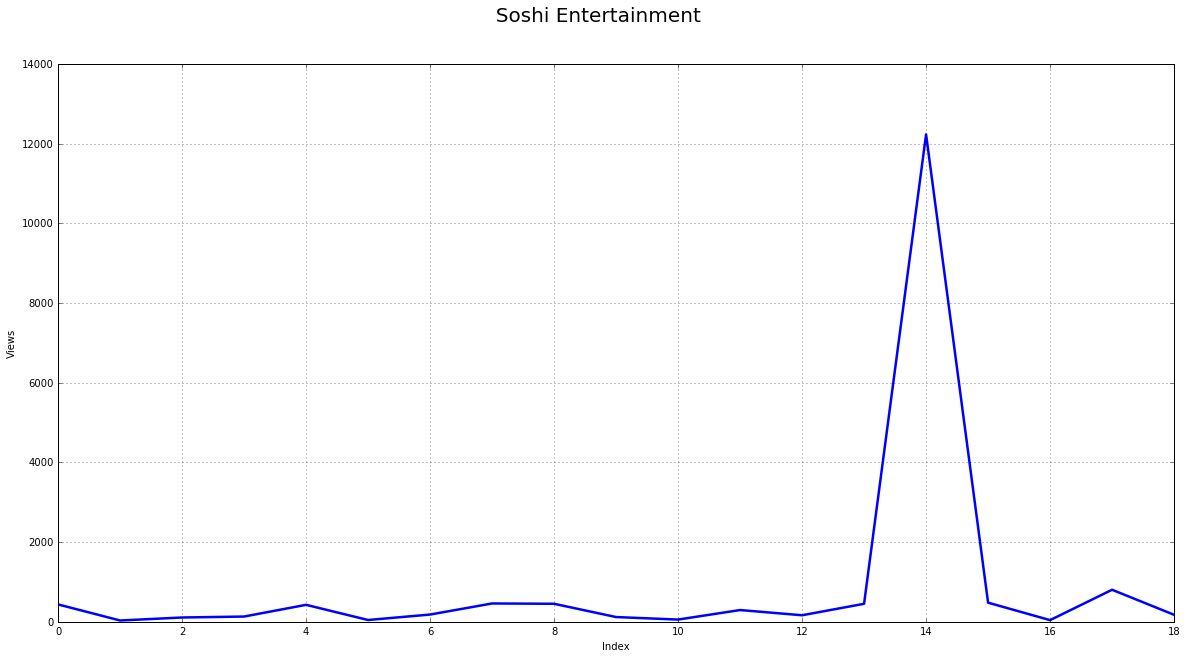

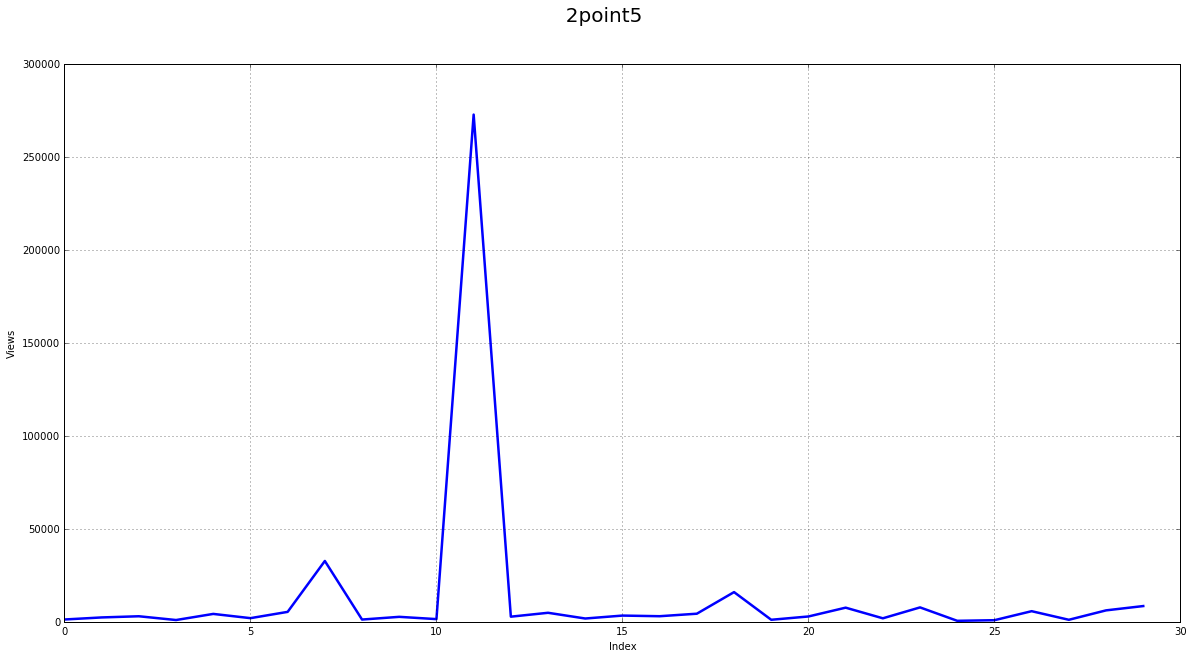

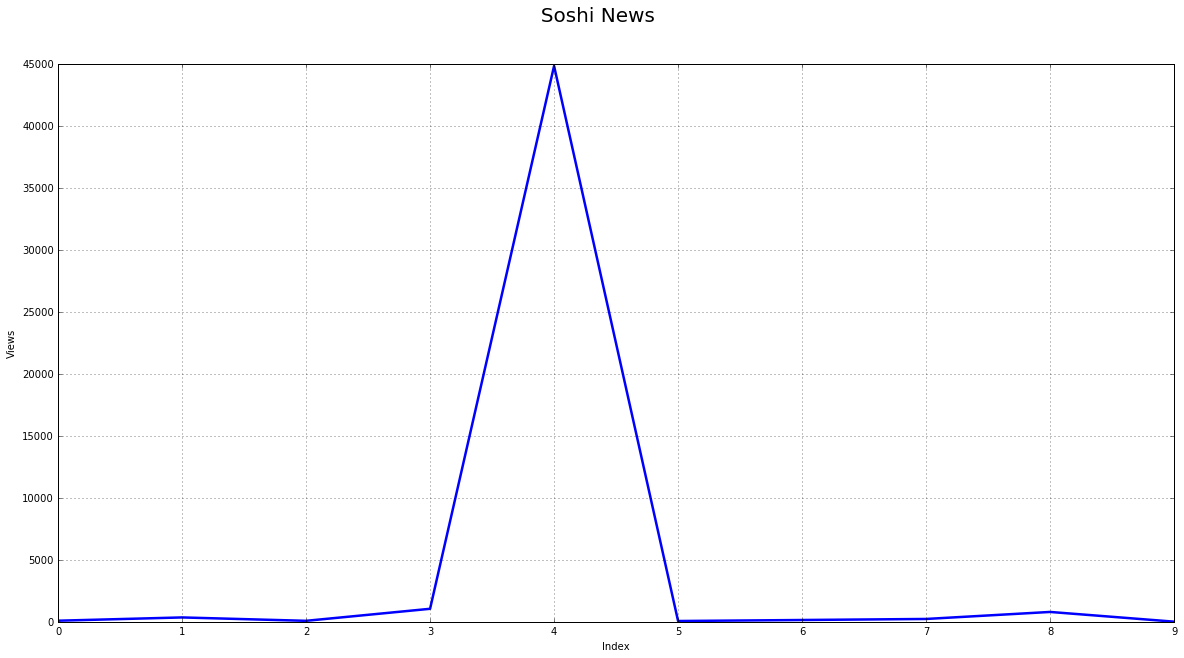

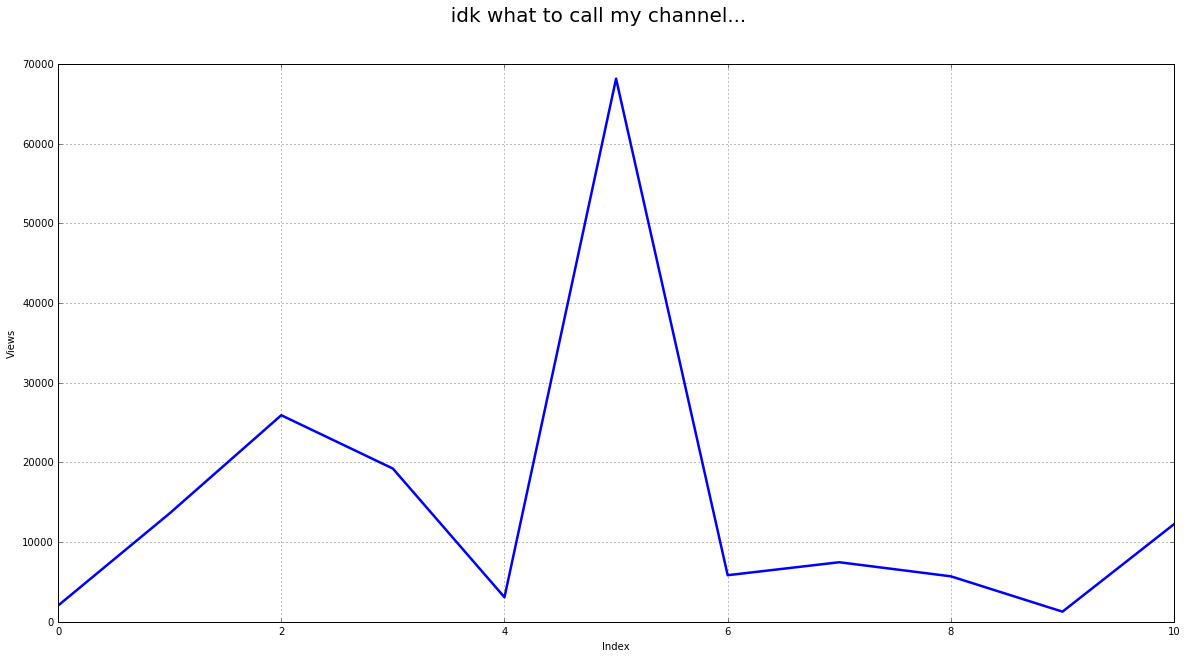

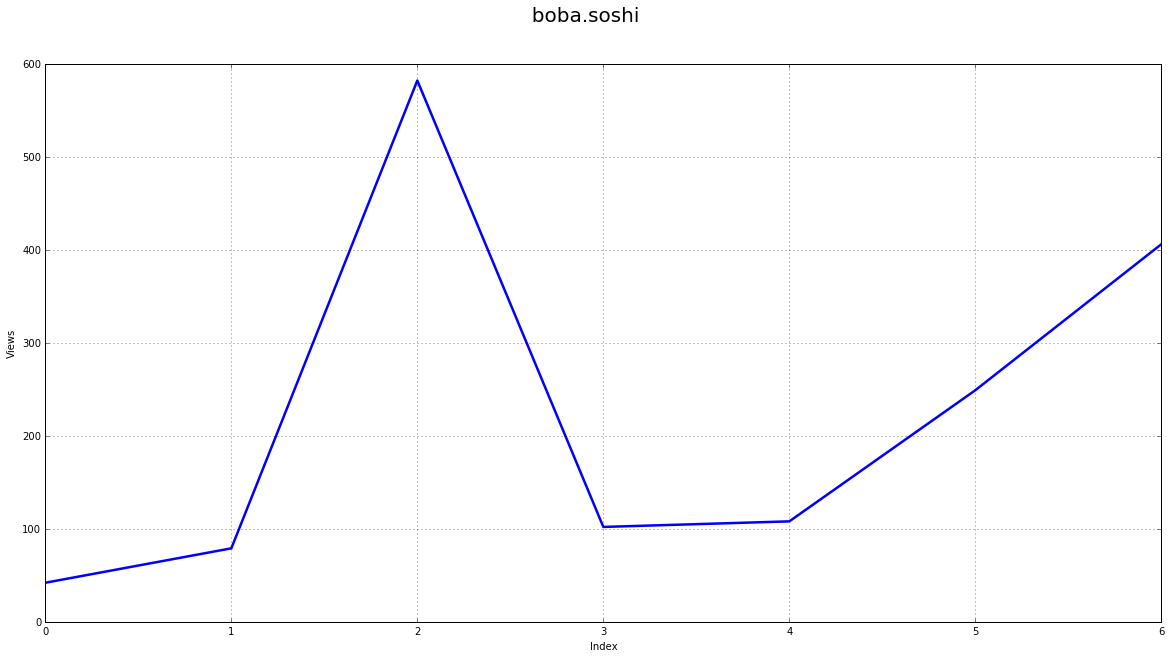

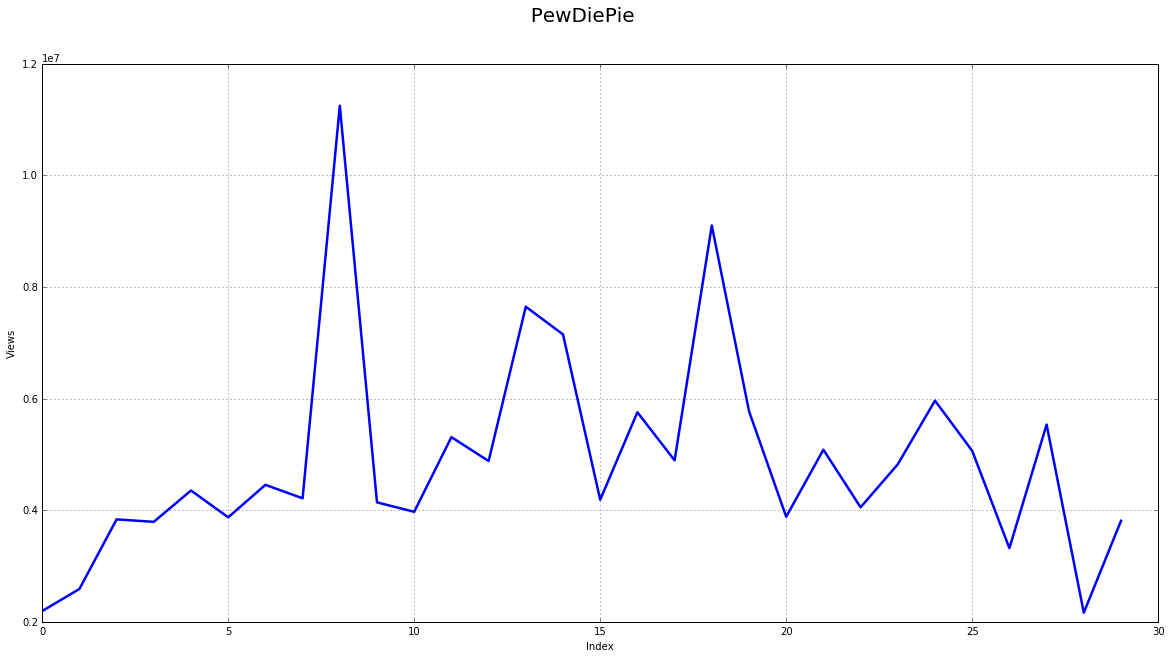

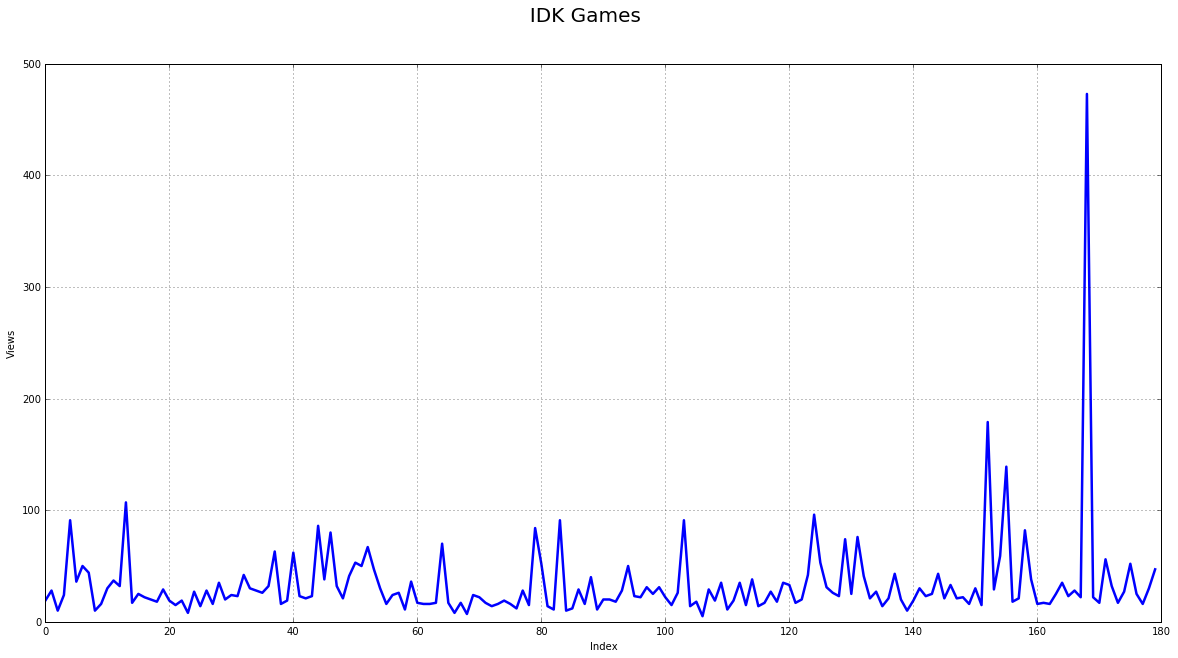

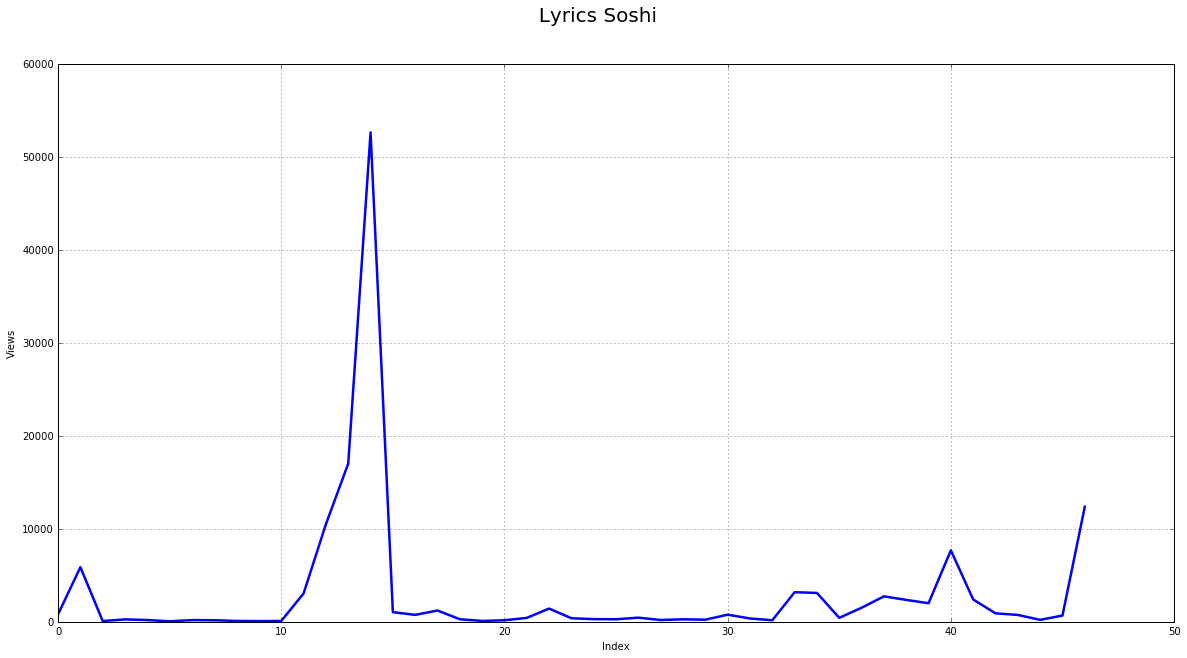

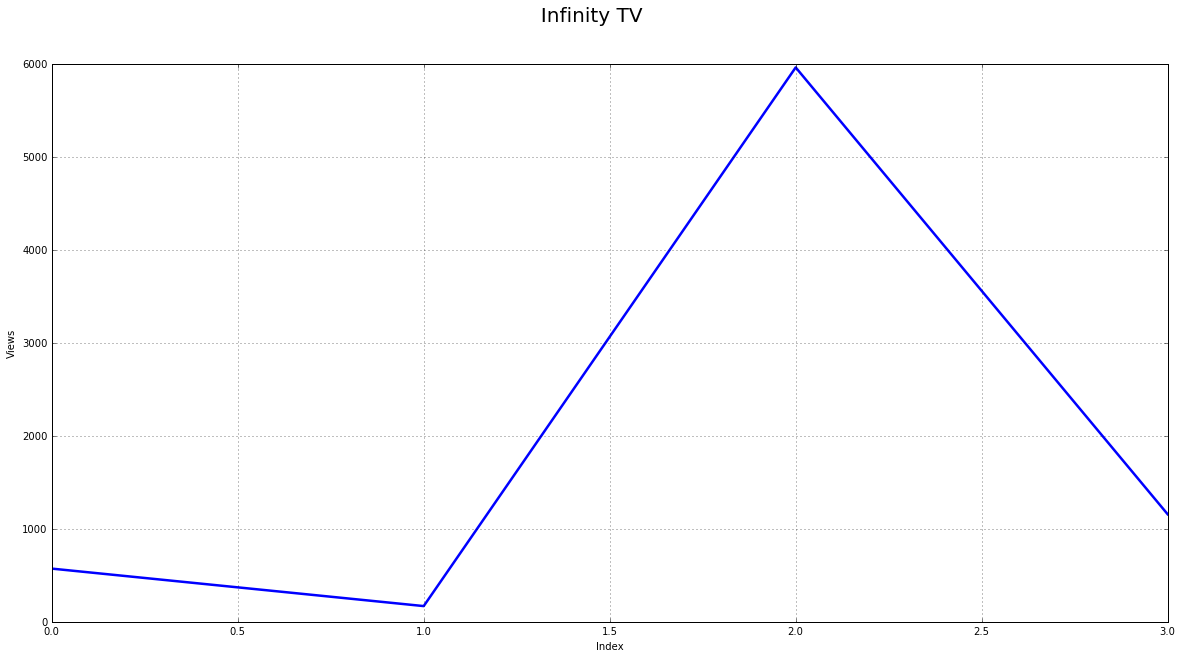

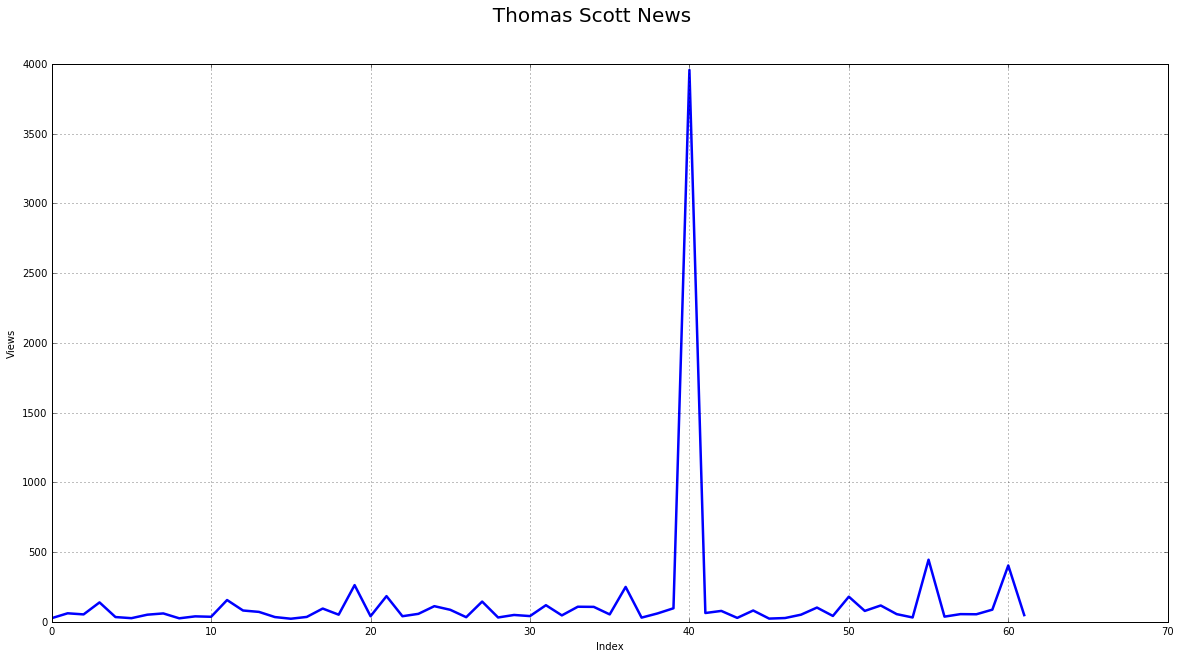

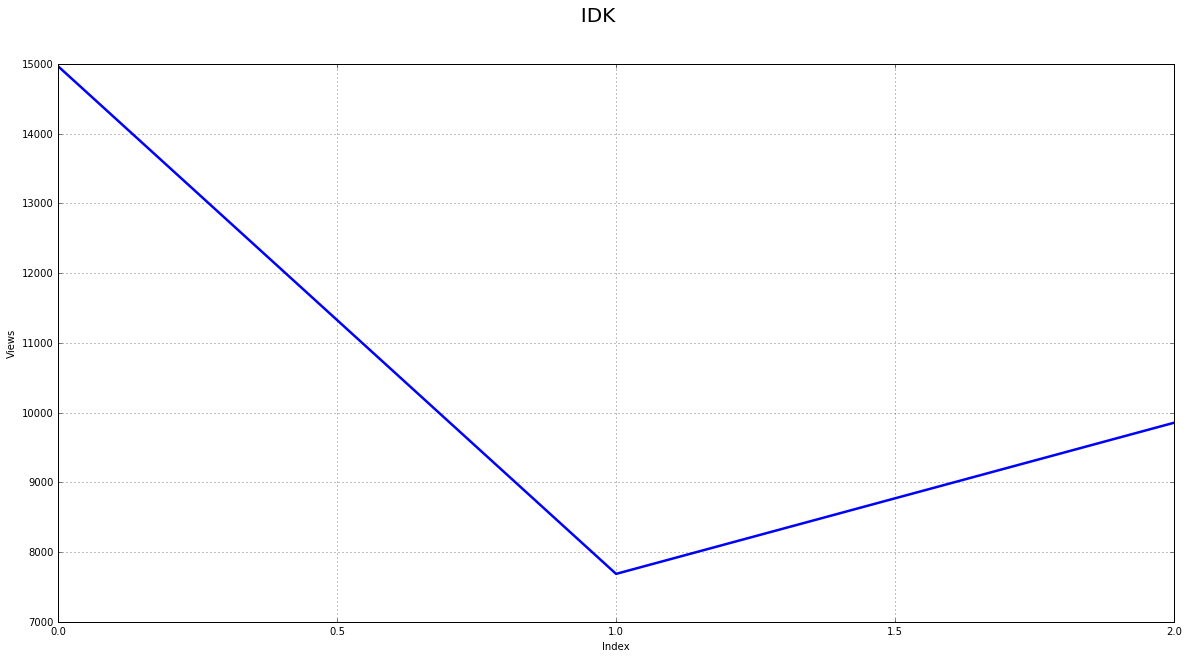

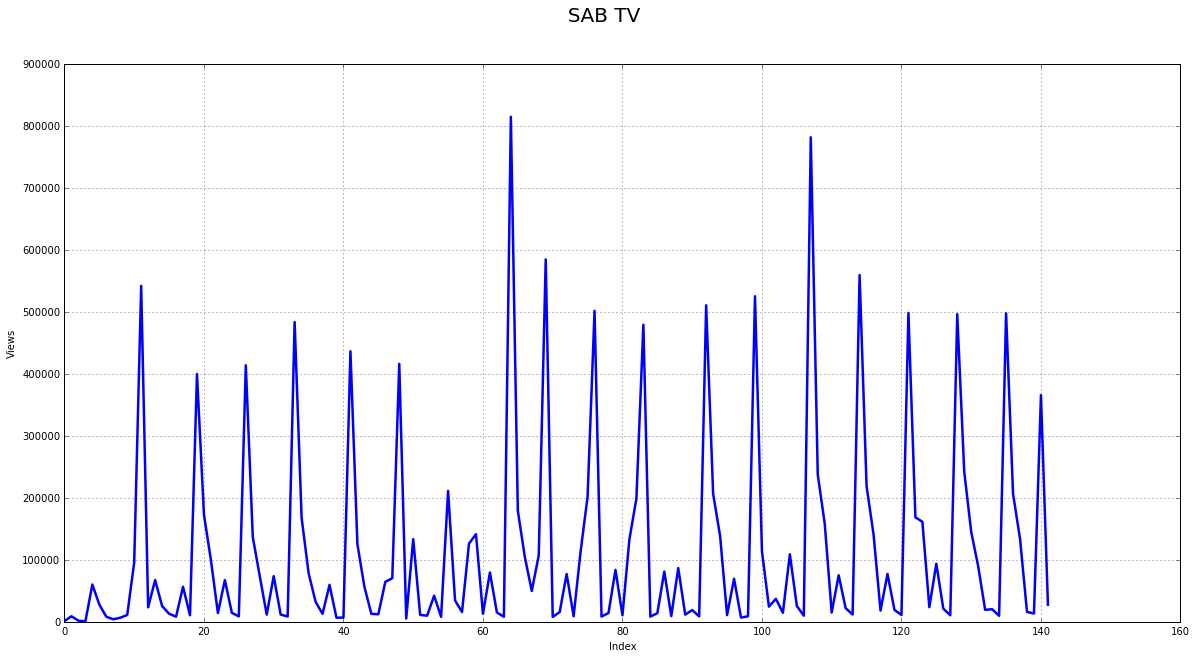

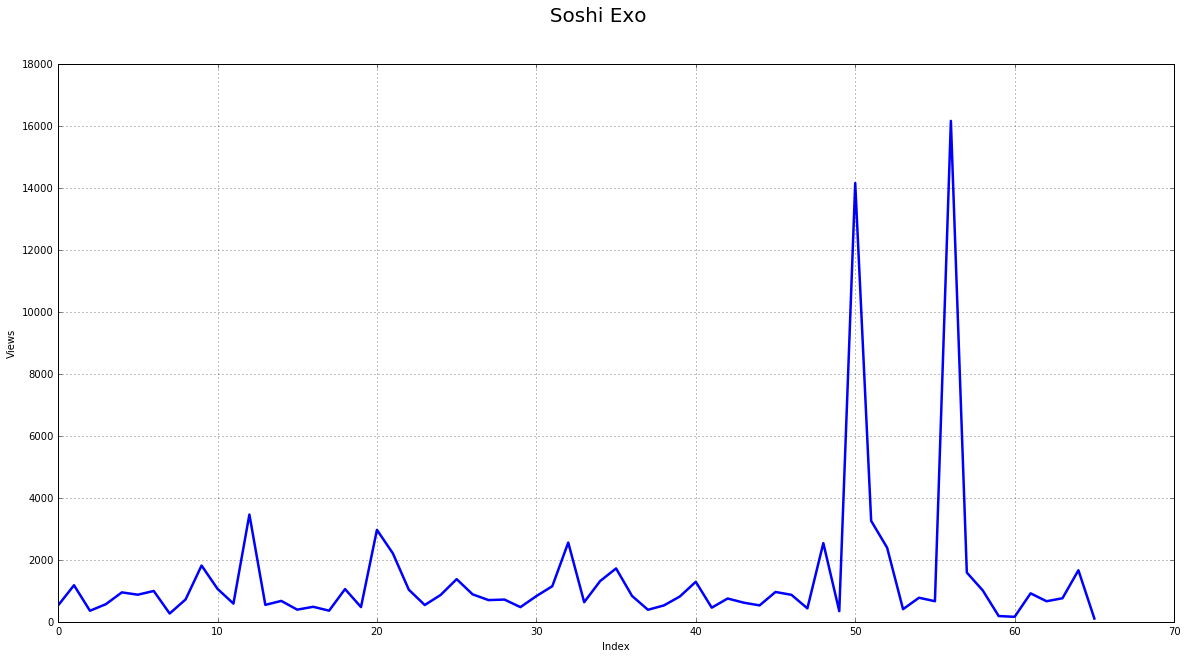

In [85]:
isSave = False
location = './GraphImage/'
def viewGraphDataFrames():
    fig = plt.figure()
    for nxtfile in os.listdir('./DataFrames'):
        df_view = pd.read_pickle('DataFrames/'+ nxtfile)
        plt.figure(figsize=(20,10), dpi=200)
        plt.plot([a.replace('views','').replace(',','').replace(' ','') for a in df_view['Views']],color="blue", linewidth=2.5, linestyle="-")
        plt.ylabel('Views')
        plt.xlabel('Index')
        plt.suptitle(nxtfile, fontsize=20)
#         plt.title(nxtfile)
        plt.grid(True)
        if isSave : plt.savefig(location+nxtfile+'.png')
        
        
        plt.show()
        
viewGraphDataFrames()